# AATau Photometry

In [21]:
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from sys import platform
from astropy.io import fits
from astropy.io import ascii
from astropy import units as u
import astropy.table as Table
from astropy.table import QTable
from dust_extinction.parameter_averages import F99
from synphot import units
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D,Empirical1D

In [22]:
# %matplotlib notebook  
%matplotlib inline

Read in data files reduced by earlier notebook:

In [23]:
data1 = ascii.read('AATau_IR2008.txt')
data2 = ascii.read('AATau_opt2008.txt')
data = Table.vstack([data2, data1])
allwav_2008=data['wavelength']
alldata_2008=data['flux']

data1 = ascii.read('AATau_IR2014dec02.txt')
data2 = ascii.read('AATau_opt2014dec02.txt')
data = Table.vstack([data2, data1])
allwav_dec02=data['wavelength']
alldata_dec02=data['flux']

data1 = ascii.read('AATau_IR2014dec12.txt')
data2 = ascii.read('AATau_opt2014dec12.txt')
data = Table.vstack([data2, data1])
allwav_dec12=data['wavelength']
alldata_dec12=data['flux']

Make an interpolation function to divide one spectrum by the other:

In [24]:
interp2008=interp.interp1d(allwav_2008,alldata_2008)

The overlaps in the spectra are not tolerated by synphot, so we sort them:

In [25]:
allwav_2008s=allwav_2008[np.argsort(allwav_2008)]
alldata_2008s=alldata_2008[np.argsort(allwav_2008)]

allwav_dec02s=allwav_dec02[np.argsort(allwav_dec02)]
alldata_dec02s=alldata_dec02[np.argsort(allwav_dec02)]

allwav_dec12s=allwav_dec12[np.argsort(allwav_dec12)]
alldata_dec12s=alldata_dec12[np.argsort(allwav_dec12)]

# By coincidence, some wavelengths are identical, so we nudge them a bit:
# WARNING!  HARD WIRED!
allwav_dec02s[2405]=np.float32(0.934964)*u.micron
allwav_dec12s[2166]=np.float32(0.913868)*u.micron
allwav_dec12s[2484]=np.float32(0.941703)*u.micron

In [26]:
# Optional, for when the STScI ftp server is not answering:
from synphot import config
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

vega = SourceSpectrum.from_vega()
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')


Create synthetic spectra with the FMUNRED model:

In [27]:
fobs1ext=dict()

j=0

for A in [2.0,4.0]:
    for R in [2.0,3.0,5.0]:
        ext=F99(Rv=R)
        fobs1ext[j]=alldata_2008s*ext.extinguish(allwav_2008s,Av=A)
        j+=1     

Calculate photometry of observed and synthetically extinguished spectra:

In [28]:
bands = [k_band,h_band,j_band,i_band,r_band,v_band,b_band]

mags1ext=np.zeros((6,7))

mags1=np.zeros(7)
mags2=np.zeros(7)
mags3=np.zeros(7)
mags4=np.zeros(7)

for j in [0,1,2,3,4,5,6]:
    sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=alldata_2008s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags1[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value # default binned=False
    sp = SourceSpectrum(Empirical1D, points=allwav_dec02s, lookup_table=alldata_dec02s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags2[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    sp = SourceSpectrum(Empirical1D, points=allwav_dec12s, lookup_table=alldata_dec12s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags3[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    
    for i in range(6):
        sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=fobs1ext[i], keep_neg=False)
        sp_obs = Observation(sp, bands[j])
        mags1ext[i,j] = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    

In [29]:
print("Date         B     V     R     I     J     H     K")
print("2008Dec28",np.round(mags1[::-1],2))
print("2014Dec02",np.round(mags2[::-1],2))
print("2014Dec12",np.round(mags3[::-1],2))

Date         B     V     R     I     J     H     K
2008Dec28 [13.99 12.85 11.57 10.54  9.48  8.64  8.13]
2014Dec02 [16.59 14.85 12.84 11.5  10.04  8.9   8.12]
2014Dec12 [16.18 14.95 12.95 11.61 10.07  8.92  8.11]


In [30]:
mags1

array([ 8.12545762,  8.63775381,  9.4796061 , 10.54233954, 11.57235532,
       12.84902046, 13.99366631])

In [31]:
mags2

array([ 8.1190166 ,  8.90018651, 10.03621318, 11.49856709, 12.84199828,
       14.84816432, 16.58947888])

In [32]:
mags3

array([ 8.11189694,  8.92168367, 10.07173608, 11.61187158, 12.95395126,
       14.94780733, 16.18287054])

In [33]:
mags1ext

array([[ 8.34920393,  8.98590141,  9.99722394, 11.32340427, 12.6551131 ,
        14.65587901, 16.74044124],
       [ 8.34196653,  8.96827834,  9.9944421 , 11.41831284, 12.82419083,
        14.72582521, 16.50511259],
       [ 8.33616823,  8.95416742,  9.9921507 , 11.49314381, 12.95895849,
        14.77624733, 16.3072267 ],
       [ 8.5726541 ,  9.33342211, 10.51339964, 12.09452271, 13.7034493 ,
        16.38573996, 19.36822833],
       [ 8.55824921,  9.29820724, 10.50705777, 12.27498226, 14.03625984,
        16.56566564, 18.96291505],
       [ 8.54670183,  9.27000966, 10.50173639, 12.41498897, 14.30036294,
        16.68845579, 18.6013921 ]])

I copy and paste into the figures file.  I'm not proud...

From Figures:

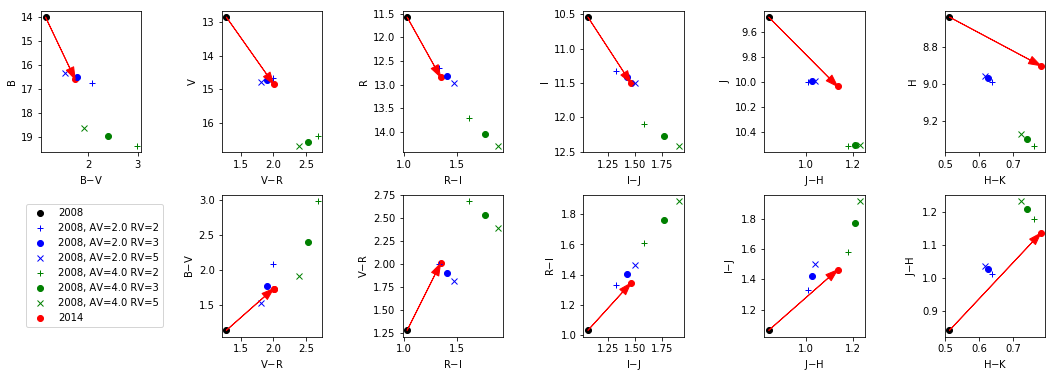

In [34]:
bands=['K','H','J','I','R','V','B']

fig,axes=plt.subplots(2,6,figsize=(18,6))

for j in [0,1,2,3,4,5]: # just data
    if j!=5:
        axes[1,5-j].plot(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1],'o',color='red')
        
        axes[1,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))
        
        axes[1,5-j].plot(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1],'o',color='black',label='2008')
        axes[1,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
        axes[1,5-j].set_ylabel(bands[j+2]+'$-$'+bands[j+1])
                           
    axes[0,5-j].plot(mags1[j+1]-mags1[j],mags1[j+1],'o',color='black')
    axes[0,5-j].plot(mags2[j+1]-mags2[j],mags2[j+1],'o',color='red')
    axes[0,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))
    axes[0,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
    axes[0,5-j].set_ylabel(bands[j+1])
    
for j in [0,1,2,3,4,5]: # extinction 
    if j!=5:
        axes[1,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+2]-mags1ext[0,j+1],'+',color='blue',label='2008, AV=2.0 RV=2')
        axes[1,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+2]-mags1ext[1,j+1],'o',color='blue',label='2008, AV=2.0 RV=3')
        axes[1,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+2]-mags1ext[2,j+1],'x',color='blue',label='2008, AV=2.0 RV=5')
        axes[1,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+2]-mags1ext[3,j+1],'+',color='green',label='2008, AV=4.0 RV=2')
        axes[1,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+2]-mags1ext[4,j+1],'o',color='green',label='2008, AV=4.0 RV=3')
        axes[1,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+2]-mags1ext[5,j+1],'x',color='green',label='2008, AV=4.0 RV=5')

    axes[0,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+1],'+',color='blue')
    axes[0,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+1],'o',color='blue')
    axes[0,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+1],'x',color='blue')
    axes[0,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+1],'+',color='green')
    axes[0,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+1],'o',color='green')
    axes[0,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+1],'x',color='green')
    
axes[1,1].plot(mags2[5]-mags2[4],mags2[6]-mags2[5],'o',color='red',label='2014') # just for the legend
axes[1,0].axis('off')
fig.subplots_adjust(wspace=0.8,hspace=0.3)
axes[1,1].legend(loc='center left', bbox_to_anchor=(-2, 0.5))
for j in [0,1,2,3,4,5]:
    axes[0,5-j].set_ylim(axes[0,5-j].get_ylim()[::-1])

plt.show()